# Testing v2
Starting with complex model

In [1]:
# LIBRERIE
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from pandas.api.types import CategoricalDtype


In [2]:
# CARICAMENTO DATI
def loadDataset(year):
    dataset_path = "../datasets/tennis/"+year+".xlsx"
    return pd.read_excel(dataset_path)

In [3]:
# Mi serve per sapere l'encoding dei giocatori 
def playEncode(df):
    playerList=set(df["Winner"]) | set(df["Loser"]) # Trovo tutti i giocatori singoli
    
    # Formattazione dei Giocatori
    playerEncode = {}
    for index, player in enumerate(playerList):
        playerEncode[player] = index
        
    return playerEncode

In [28]:
# Formattazione generale del dataset
# Player Encode = 0, in questi test provo a lasciare i nomi dei giocatori per esteso
# poichè non li utilizzerò per la previsione
def generalFormatting(dfCopy, playerEncode = 0):
    
    df = dfCopy.copy()
    
    # Cambio nome delle colonne Winner/Loser
    dictCol = {'Winner' :"Player1", 'Loser':'Player2', 'WRank':'P1_Rank', 'LRank':'P2_Rank', 'WPts':'P1_Pts', 'LPts':'P2_Pts',
       'W1':'P1_S1', 'L1':'P2_S1', 'W2':'P1_S2', "L2":'P2_S2', 'W3':'P1_S3', 'L3':'P2_S3', 'W4':'P1_S4', 'L4':'P2_S4', 'W5':'P1_S5', "L5":'P2_S5', 'Wsets':'P1_sets',
       'Lsets':'P2_sets', 'B365W':'P1_B365', 'B365L':'P2_B365', 'EXW':'P1_EX', 'EXL':'P2_EX', 'LBW':'P1_LB', 'LBL':'P2_LB', 'PSW':'P1_PS',
       'PSL':'P2_PS', 'MaxW':'P1_Max', 'MaxL':'P2_Max', 'AvgW':'P1_Avg', 'AvgL':'P2_Avg'}

    df.rename(columns=dictCol, inplace=True)
    
    # df.replace({"Player1":playerEncode, "Player2":playerEncode}, inplace = True)
    
    # Fill NA
    df.fillna(0, inplace = True)
    
    # One Hot Encoding
    df = pd.get_dummies(df, columns = ["Court", "Surface","Comment", "Best of"])
    
    # Encoding Tipo torneo con peso
    df["Series"]=df["Series"].astype('category')
    cats_to_order = ["ATP250", "ATP500", "Masters 1000", "Masters Cup", "Grand Slam"]
    covered_type = CategoricalDtype(categories=cats_to_order, ordered=True)
    df['Series'] = df['Series'].cat.reorder_categories(cats_to_order, ordered=True)
    df["Series"] = df["Series"].cat.codes
    
    # Encoding Round Torneo con peso
    df["Round"]=df["Round"].astype('category')
    cats_to_order = ["Round Robin", "1st Round",'2nd Round','3rd Round','4th Round','Quarterfinals', 'Semifinals', 'The Final']
    covered_type = CategoricalDtype(categories=cats_to_order, ordered=True)
    df['Round'] = df['Round'].cat.reorder_categories(cats_to_order, ordered=True)
    df["Round"] = df["Round"].cat.codes
    
    # Rimozione colonne influenti
    df.drop(["Location", "ATP"], axis =1, inplace=True)
    
    # Encoding Nome tornei
    lb_make = LabelEncoder()
    df["Tournament"] = lb_make.fit_transform(df["Tournament"])
    df["target"] = 0
    
    return df
    

In [29]:
# Swap tra due valori
def swap (a,b):
    c=a
    a=b
    b=c
    return a,b

# Effetua lo swap dei valori di una riga
def swapP1P2 (row):
    copy = row.copy()
    swapCol=['Player1', 'Player2', 'P1_Rank', 'P2_Rank', 'P1_Pts', 'P2_Pts', 'P1_S1', 'P2_S1', 'P1_S2', 'P2_S2', 'P1_S3', 'P2_S3', 'P1_S4', 'P2_S4', 'P1_S5', 'P2_S5',
       'P1_sets', 'P2_sets', 'P1_B365', 'P2_B365', 'P1_EX', 'P2_EX', 'P1_LB', 'P2_LB', 'P1_PS', 'P2_PS', 'P1_Max', 'P2_Max', 'P1_Avg', 'P2_Avg']
    
    for i in range(0, int(len(swapCol)/2)):
        index=i*2
        aa = swapCol[index]
        bb = swapCol[index+1]
        copy[aa],copy[bb] = swap(copy[aa],copy[bb])
        copy["target"] = np.where (copy["target"] == 0, 1, 0)
        
    return copy
        
# Data un dataframe fa swap di colonne di righe random
def randomSwap(df):
    maxRow = df.shape[0]
    for i in range(0,1000):
        pos = np.random.randint(0,maxRow)
        df.loc[pos] = swapP1P2(df.loc[pos])

In [30]:
dfTree = loadDataset("2016")
dfTree.head()

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,EXW,EXL,LBW,LBL,PSW,PSL,MaxW,MaxL,AvgW,AvgL
0,1,Brisbane,Brisbane International,2016-01-04,ATP250,Outdoor,Hard,1st Round,3,Dimitrov G.,...,1.68,2.10,1.62,2.25,1.68,2.31,1.76,2.35,1.66,2.20
1,1,Brisbane,Brisbane International,2016-01-04,ATP250,Outdoor,Hard,1st Round,3,Kudla D.,...,1.58,2.35,1.53,2.50,1.63,2.40,1.63,2.50,1.57,2.37
2,1,Brisbane,Brisbane International,2016-01-04,ATP250,Outdoor,Hard,1st Round,3,Kamke T.,...,1.82,1.90,1.80,2.00,1.90,1.99,1.90,2.10,1.77,2.00
3,1,Brisbane,Brisbane International,2016-01-04,ATP250,Outdoor,Hard,1st Round,3,Chung H.,...,1.82,1.90,1.73,2.10,1.93,1.96,1.93,2.10,1.82,1.95
4,1,Brisbane,Brisbane International,2016-01-05,ATP250,Outdoor,Hard,1st Round,3,Goffin D.,...,1.30,3.40,1.29,3.75,1.31,3.74,1.31,3.80,1.29,3.56


In [7]:
# Tryng to not ecode the player name, is necessary ?

# playerEncodeDfTree = playEncode(dfTree)

In [31]:
dfTreeFormatted = generalFormatting(dfTree)

In [32]:
randomSwap(dfTreeFormatted)

In [33]:
dfTreeFormatted.columns

Index(['Tournament', 'Date', 'Series', 'Round', 'Player1', 'Player2',
       'P1_Rank', 'P2_Rank', 'P1_Pts', 'P2_Pts', 'P1_S1', 'P2_S1', 'P1_S2',
       'P2_S2', 'P1_S3', 'P2_S3', 'P1_S4', 'P2_S4', 'P1_S5', 'P2_S5',
       'P1_sets', 'P2_sets', 'P1_B365', 'P2_B365', 'P1_EX', 'P2_EX', 'P1_LB',
       'P2_LB', 'P1_PS', 'P2_PS', 'P1_Max', 'P2_Max', 'P1_Avg', 'P2_Avg',
       'Court_Indoor', 'Court_Outdoor', 'Surface_Clay', 'Surface_Grass',
       'Surface_Hard', 'Comment_Completed', 'Comment_Retired',
       'Comment_Walkover', 'Best of_3', 'Best of_5', 'target'],
      dtype='object')

In [34]:
# Drop di tutte le colonne che non ho al momento della previsione
noInfoCol = ['P1_S1', 'P2_S1', 'P1_S2',
       'P2_S2', 'P1_S3', 'P2_S3', 'P1_S4', 'P2_S4', 'P1_S5', 'P2_S5',
       'P1_sets', 'P2_sets', 'P1_B365', 'P2_B365', 'P1_EX', 'P2_EX', 'P1_LB',
       'P2_LB', 'P1_PS', 'P2_PS', 'P1_Max', 'P2_Max', 'P1_Avg', 'P2_Avg',
       'Court_Indoor', 'Court_Outdoor', 'Surface_Clay', 'Surface_Grass',
       'Surface_Hard', 'Comment_Completed', 'Comment_Retired',
       'Comment_Walkover', 'Best of_3', 'Best of_5']

In [35]:
dfTreeFormatted.drop(noInfoCol, axis = 1, inplace = True)

In [36]:
# drop della data
dfTreeFormatted.drop("Date", axis = 1, inplace = True)

In [37]:
dfTreeFormatted

,Tournament,Series,Round,Player1,Player2,P1_Rank,P2_Rank,P1_Pts,P2_Pts,target
0,15,0,1,Dimitrov G.,Simon G.,28.0,15.0,1360.0,2145.0,0
1,15,0,1,Kudla D.,Smith J.P.,69.0,129.0,719.0,459.0,0
2,15,0,1,Kamke T.,Mitchell B.,277.0,231.0,185.0,225.0,0
3,15,0,1,Chung H.,Groth S.,51.0,60.0,817.0,782.0,0
4,15,0,1,Goffin D.,Bellucci T.,16.0,37.0,1880.0,1105.0,0
...,...,...,...,...,...,...,...,...,...,...
2621,37,3,0,Wawrinka S.,Murray A.,3.0,1.0,5115.0,11185.0,1
2622,37,3,0,Cilic M.,Nishikori K.,7.0,5.0,3450.0,4705.0,0
2623,37,3,6,Murray A.,Raonic M.,1.0,4.0,11185.0,5050.0,0
2624,37,3,6,Djokovic N.,Nishikori K.,2.0,5.0,10780.0,4705.0,0


In [38]:
# Rimuovo anche i giocatori perchè l'albero non ha senso che splitti per quei valori
dfTreeFormattedPlayer = dfTreeFormatted[["Player1", "Player2"]]
dfTreeFormatted.drop(["Player1", "Player2"], axis = 1, inplace = True)

In [39]:
from sklearn.model_selection import train_test_split

X = dfTreeFormatted.drop("target", axis = 1)
y= dfTreeFormatted["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Test Accuracy: 0.6585928489042676


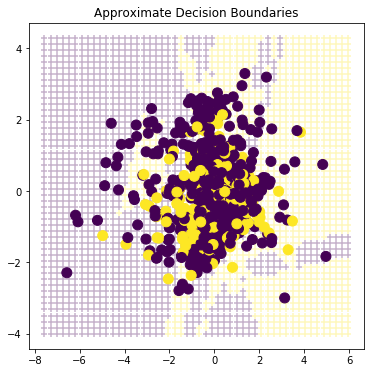

In [40]:
# Decision boundary ploy
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# needed for PCA
scaler = StandardScaler()
scaler.fit(X_train)

# training a decision tree
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion='gini') # try gini vs. entropy
dt.fit( scaler.transform(X_train),
        y_train)
# make it 2d
pca = PCA(n_components=2)
pca.fit( scaler.transform(X_train) )

# create projection grid starting form test points
X_2d = pca.transform( scaler.transform(X_test) )
x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
zz = [ [xx,yy] for xx in np.linspace(x_min, x_max, 50) 
               for yy in np.linspace(y_min, y_max, 50) ]
zz = np.array(zz)
Z = dt.predict(pca.inverse_transform(zz))

# Put the result into a color plot
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(zz[:,0], zz[:,1], c=Z, marker='+', alpha=0.3)

# Plot also the test points
ax.scatter(X_2d[:, 0], X_2d[:, 1], c=y_test, s=100)

ax.set_title("Approximate Decision Boundaries")

# compute Accuracy

from sklearn.metrics import accuracy_score
y_pred = dt.predict(scaler.transform(X_test))

print ("Test Accuracy:", accuracy_score(y_true=y_test, y_pred=y_pred) )


In [41]:
# MAX Leaves stop criteria
from sklearn import tree

for max_leaves in range(2,20):
    # train and predict
    dt = tree.DecisionTreeClassifier(max_leaf_nodes=max_leaves)
    dt.fit(X_train,y_train)

    # compute Accuracy
    train_acc = accuracy_score(y_true=y_train, y_pred=dt.predict(X_train))
    test_acc = accuracy_score(y_true=y_test, y_pred=dt.predict(X_test))
    print ("Leaves:", max_leaves, " - Train Accuracy:", train_acc, " - Test Accuracy:", test_acc)


Leaves: 2  - Train Accuracy: 0.7288231949971575  - Test Accuracy: 0.7243367935409458
Leaves: 3  - Train Accuracy: 0.7288231949971575  - Test Accuracy: 0.7243367935409458
Leaves: 4  - Train Accuracy: 0.7288231949971575  - Test Accuracy: 0.7243367935409458
Leaves: 5  - Train Accuracy: 0.7322342239909039  - Test Accuracy: 0.7243367935409458
Leaves: 6  - Train Accuracy: 0.7515633882888004  - Test Accuracy: 0.7335640138408305
Leaves: 7  - Train Accuracy: 0.7578169414440022  - Test Accuracy: 0.7220299884659747
Leaves: 8  - Train Accuracy: 0.7589539511085844  - Test Accuracy: 0.71280276816609
Leaves: 9  - Train Accuracy: 0.7623649801023309  - Test Accuracy: 0.7174163783160323
Leaves: 10  - Train Accuracy: 0.7623649801023309  - Test Accuracy: 0.7174163783160323
Leaves: 11  - Train Accuracy: 0.7623649801023309  - Test Accuracy: 0.7174163783160323
Leaves: 12  - Train Accuracy: 0.7623649801023309  - Test Accuracy: 0.7174163783160323
Leaves: 13  - Train Accuracy: 0.7623649801023309  - Test Accurac

In [42]:
# MAX depths stop criteria

for max_depth in range(1,20):
    # train and predict
    dt = tree.DecisionTreeClassifier(max_depth=max_depth)
    dt.fit(X_train,y_train)

    # compute Accuracy
    train_acc = accuracy_score(y_true=y_train, y_pred=dt.predict(X_train))
    test_acc = accuracy_score(y_true=y_test, y_pred=dt.predict(X_test))
    print ("Depth:", max_depth, " - Train Accuracy:", train_acc, " - Test Accuracy:", test_acc)

Depth: 1  - Train Accuracy: 0.7288231949971575  - Test Accuracy: 0.7243367935409458
Depth: 2  - Train Accuracy: 0.7322342239909039  - Test Accuracy: 0.7243367935409458
Depth: 3  - Train Accuracy: 0.7521318931210915  - Test Accuracy: 0.7324106113033448
Depth: 4  - Train Accuracy: 0.7623649801023309  - Test Accuracy: 0.7001153402537486
Depth: 5  - Train Accuracy: 0.7788516202387721  - Test Accuracy: 0.7220299884659747
Depth: 6  - Train Accuracy: 0.7919272313814667  - Test Accuracy: 0.7185697808535179
Depth: 7  - Train Accuracy: 0.8146674246731097  - Test Accuracy: 0.7012687427912342
Depth: 8  - Train Accuracy: 0.8328595793064241  - Test Accuracy: 0.7012687427912342
Depth: 9  - Train Accuracy: 0.8646958499147243  - Test Accuracy: 0.707035755478662
Depth: 10  - Train Accuracy: 0.885730528709494  - Test Accuracy: 0.7001153402537486
Depth: 11  - Train Accuracy: 0.9147242751563388  - Test Accuracy: 0.6793540945790081
Depth: 12  - Train Accuracy: 0.9363274587833996  - Test Accuracy: 0.66551326

In [43]:
# Trying train - validation - test Split

# this is a 60/20/20 split
X_train_80, X_test, y_train_80, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_80, y_train_80, test_size=0.25, random_state=42)

accuracies = []

for max_leaves in range(2,20):
    # train and predict
    dt = tree.DecisionTreeClassifier(max_leaf_nodes=max_leaves)
    dt.fit(X_train,y_train)

    # compute Accuracy
    train_acc = accuracy_score(y_true=y_train, y_pred=dt.predict(X_train))
    valid_acc = accuracy_score(y_true=y_valid, y_pred=dt.predict(X_valid))
    print ("Leaves: {:2d} - Train Accuracy: {:.3f} - Validation Accuracy: {:.3f}".format(
        max_leaves,  train_acc, valid_acc) )
    
    accuracies += [ [valid_acc, max_leaves] ]

best_accuracy, best_max_leaves = max(accuracies)
print ( "Best Max Leaves", best_max_leaves )

# here we are using both training and validation,
# to exploit the most data
dt = tree.DecisionTreeClassifier(max_leaf_nodes=best_max_leaves)
dt.fit(X_train_80,y_train_80)

test_acc = accuracy_score(y_true=y_test, y_pred=dt.predict(X_test))
print ("Test Accuracy: {:.3f}".format(test_acc) )

Leaves:  2 - Train Accuracy: 0.726 - Validation Accuracy: 0.718
Leaves:  3 - Train Accuracy: 0.726 - Validation Accuracy: 0.718
Leaves:  4 - Train Accuracy: 0.732 - Validation Accuracy: 0.716
Leaves:  5 - Train Accuracy: 0.736 - Validation Accuracy: 0.709
Leaves:  6 - Train Accuracy: 0.759 - Validation Accuracy: 0.710
Leaves:  7 - Train Accuracy: 0.759 - Validation Accuracy: 0.710
Leaves:  8 - Train Accuracy: 0.759 - Validation Accuracy: 0.710
Leaves:  9 - Train Accuracy: 0.763 - Validation Accuracy: 0.714
Leaves: 10 - Train Accuracy: 0.766 - Validation Accuracy: 0.712
Leaves: 11 - Train Accuracy: 0.769 - Validation Accuracy: 0.710
Leaves: 12 - Train Accuracy: 0.771 - Validation Accuracy: 0.710
Leaves: 13 - Train Accuracy: 0.775 - Validation Accuracy: 0.710
Leaves: 14 - Train Accuracy: 0.775 - Validation Accuracy: 0.710
Leaves: 15 - Train Accuracy: 0.776 - Validation Accuracy: 0.710
Leaves: 16 - Train Accuracy: 0.775 - Validation Accuracy: 0.710
Leaves: 17 - Train Accuracy: 0.776 - Val

# Confusion Matrix


In [44]:
from sklearn.metrics import confusion_matrix, classification_report

dt = DecisionTreeClassifier(max_leaf_nodes=27)
dt.fit(X_train,y_train)

train_acc = accuracy_score(y_true=y_train, y_pred=dt.predict(X_train))
valid_acc = accuracy_score(y_true=y_valid, y_pred=dt.predict(X_valid))
test_acc  = accuracy_score(y_true=y_test,  y_pred=dt.predict(X_test))

print ("Train Acc:", train_acc)
print ("Valid Acc:", valid_acc)
print ("Test Acc :", test_acc)

Train Acc: 0.7873015873015873
Valid Acc: 0.6895238095238095
Test Acc : 0.714828897338403


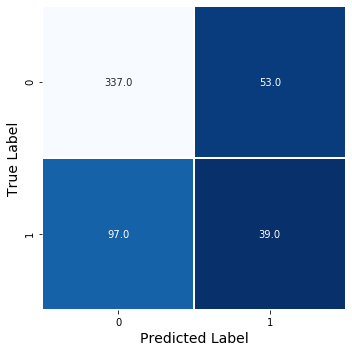

In [45]:

conf_stat = confusion_matrix(y_true=y_test, y_pred=dt.predict(X_test))

# This is a powerful plotting lib !!!
# If doesn't work downgrade matplotlib at 3.1.0
import seaborn as sns

fig, ax = plt.subplots(figsize=(5,5), tight_layout=True)
sns.heatmap(conf_stat, annot=True, fmt=".1f", 
            linewidths=.5, square = True, 
            cmap = 'Blues_r',cbar=False,
            xticklabels=dt.classes_,
            yticklabels=dt.classes_);

ax.set_ylabel('True Label', fontsize=14);
ax.set_xlabel('Predicted Label', fontsize=14);

# Creating new columns and trying complex model

In [46]:
# Crea una matrice di Giocatore X Giocatore segnando quante volte uno a vinto contro un altro
def playerDf(df_old, df_new):
    playerList=set(df_old["Winner"]) | set(df_old["Loser"]) | set(df_new["Winner"]) | set(df_new["Loser"]) # Trovo tutti i giocatori singoli
    
    newDf= pd.DataFrame(data = 0, index=playerList, columns=playerList) # Creo un dataframe per vedere chi vince con chi
    
    winLoseDf = df_old[["Winner","Loser"]] # Per popolarlo prendo chi vince e chi perde
    
    for index, row in winLoseDf.iterrows(): 
        # Doing +2 and +1 for the loser for "smoothing"
        newDf.loc[row["Winner"],row["Loser"]]+=2
        newDf.loc[row["Loser"],row["Winner"]]+=1
        
    return newDf

In [47]:
# Mi serve per calcore il rateo di vittoria di un giocatore, se i giocatori non hanno giocato è 0.5
def rateo(p1, p2, wl):
    if wl.loc[p1, p2] == 0 and wl.loc[p2, p1] == 0:
        return 0.5
    else:
        return wl.loc[p1, p2] / (wl.loc[p1, p2]+wl.loc[p2,p1]) 

In [48]:
# Need new dataset where put the history data
df_new = loadDataset("2017")

In [49]:
# Creating player matrix with previews year 
playerMatrix = playerDf(dfTree, df_new)
# playerMatrix

,Hanfmann Y.,Edmund K.,Smith J.P.,Federer R.,Stepanek R.,Montanes A.,Haase R.,Delbonis F.,Giannessi A.,Martin A.,...,Jaziri M.,De Loore J.,Sousa P.,Ram R.,Soeda G.,Duckworth J.,Berdych T.,Medvedev D.,Bellotti R.,Quinzi G.
Hanfmann Y.,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Edmund K.,0,0,0,0,0,0,0,2,0,0,...,0,0,0,2,0,0,1,0,0,0
Smith J.P.,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Federer R.,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,2,0,0,0
Stepanek R.,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Duckworth J.,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Berdych T.,0,2,0,1,0,0,0,0,0,0,...,2,0,0,2,0,0,0,0,0,0
Medvedev D.,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bellotti R.,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
# Adding new feature

df_new["P1_WinRateo"] = 0
df_new["P2_WinRateo"] = 0

for index, row in df_new.iterrows():
    df_new.loc[index,"P1_WinRateo"] = rateo(row["Winner"],row["Loser"],playerMatrix)
    df_new.loc[index, "P2_WinRateo"] = rateo(row["Loser"],row["Winner"],playerMatrix)
    # print(row["P1_WinRateo"], row["P2_WinRateo"])

# df_new

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,LBW,LBL,PSW,PSL,MaxW,MaxL,AvgW,AvgL,P1_WinRateo,P2_WinRateo
0,1,Brisbane,Brisbane International,2017-01-01,ATP250,Outdoor,Hard,1st Round,3,Thompson J.,...,1.30,3.50,1.31,3.73,1.33,3.90,1.29,3.50,0.500000,0.500000
1,1,Brisbane,Brisbane International,2017-01-02,ATP250,Outdoor,Hard,1st Round,3,Mahut N.,...,1.53,2.50,1.58,2.52,1.59,2.55,1.54,2.43,0.500000,0.500000
2,1,Brisbane,Brisbane International,2017-01-02,ATP250,Outdoor,Hard,1st Round,3,Ferrer D.,...,2.00,1.80,2.10,1.81,2.15,1.82,2.01,1.77,0.500000,0.500000
3,1,Brisbane,Brisbane International,2017-01-02,ATP250,Outdoor,Hard,1st Round,3,Edmund K.,...,1.40,3.00,1.42,3.09,1.42,3.25,1.37,3.01,0.666667,0.333333
4,1,Brisbane,Brisbane International,2017-01-02,ATP250,Outdoor,Hard,1st Round,3,Dimitrov G.,...,1.40,3.00,1.41,3.13,1.46,3.13,1.41,2.85,0.555556,0.444444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2628,67,London,Masters Cup,2017-11-17,Masters Cup,Indoor,Hard,Round Robin,3,Goffin D.,...,2.00,1.80,2.13,1.80,2.15,1.91,2.05,1.79,0.500000,0.500000
2629,67,London,Masters Cup,2017-11-17,Masters Cup,Indoor,Hard,Round Robin,3,Dimitrov G.,...,1.22,4.33,1.24,4.57,1.29,4.57,1.23,4.25,0.333333,0.666667
2630,67,London,Masters Cup,2017-11-18,Masters Cup,Indoor,Hard,Semifinals,3,Goffin D.,...,7.50,1.08,10.37,1.08,10.37,1.12,8.45,1.08,0.333333,0.666667
2631,67,London,Masters Cup,2017-11-18,Masters Cup,Indoor,Hard,Semifinals,3,Dimitrov G.,...,1.40,2.75,1.44,3.07,1.45,3.20,1.40,2.95,0.500000,0.500000
